<a href="https://colab.research.google.com/github/BrajanNieto/MultiDiag-AI/blob/main/Anemic_Model_BN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IA Fundamentals - Anemia Detection using CNN**

---

This notebook contains the implementation and experimental analysis of Convolutional Neural Networks (CNN) applied to the automated detection of anemia. The project focuses on the processing of palpebral conjunctiva images captured via smartphone to provide a non-invasive pre-diagnosis. It evaluates:

* **Architecture Performance:** Comparison between custom CNN architectures and Transfer Learning models (e.g., MobileNetV2, EfficientNet).
* **Image Optimization:** Preprocessing techniques including color constant algorithms and ROI (Region of Interest) extraction.
* **Medical Evaluation Metrics:** Focus on Sensitivity (Recall) and F1-Score to ensure high reliability in clinical screening.

**Authors:**

Brajan Esteban Nieto Espinoza  
[brajan.nieto@utec.edu.pe](mailto:brajan.nieto@utec.edu.pe)

Mateo Tapia Chasquibol  

Sebastián López Medina  

---

In [1]:
# ==========================================
# 0. Librería
# ==========================================
import os
import pandas as pd
import glob

In [3]:
# ==========================================
# 1. Cargar Datos
# ==========================================
if not os.path.exists('/content/MultiDiag-AI'):
    !git clone https://github.com/BrajanNieto/MultiDiag-AI.git
else:
    print("El repositorio ya está clonado. Haciendo pull para actualizar...")
    !cd /content/MultiDiag-AI && git pull

BASE_PATH = '/content/MultiDiag-AI'

Cloning into 'MultiDiag-AI'...
remote: Enumerating objects: 1592, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1592 (delta 0), reused 0 (delta 0), pack-reused 1589 (from 2)
Receiving objects: 100% (1592/1592), 639.94 MiB | 25.01 MiB/s, done.
Updating files: 100% (1577/1577), done.


In [4]:
import os

print("🔧 Instalando y configurando Git LFS...")
# 1. Instalar soporte para LFS
!sudo apt-get install git-lfs
!git lfs install

# 2. Forzar la descarga de los archivos reales (binarios)
print("📥 Descargando imágenes reales (esto puede tardar unos minutos)...")
!cd /content/MultiDiag-AI && git lfs pull

# 3. Verificación de peso
# Vamos a revisar una de las imágenes que antes fallaba.
# Si pesa pocos bytes, sigue mal. Si pesa KB o MB, ya está bien.
test_img = '/content/MultiDiag-AI/India/1/20200118_164733_palpebral.png'

if os.path.exists(test_img):
    size = os.path.getsize(test_img)
    print(f"\nTamaño del archivo de prueba: {size} bytes")
    if size < 2000: # Menos de 2KB
        print("⚠ ALERTA: La imagen sigue siendo un puntero LFS. Algo falló en la descarga.")
    else:
        print("✅ ÉXITO: La imagen tiene un tamaño real. Ya puedes entrenar.")
else:
    print("El archivo de prueba no existe (quizás cambiaste la ruta).")

🔧 Instalando y configurando Git LFS...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
Git LFS initialized.
📥 Descargando imágenes reales (esto puede tardar unos minutos)...

Tamaño del archivo de prueba: 321769 bytes
✅ ÉXITO: La imagen tiene un tamaño real. Ya puedes entrenar.


In [5]:
# ==========================================
# 2. Configuración de filtros (India / Italy)
# ==========================================
SUFFIX_INCLUDE = "palpebral.png"
SUFFIX_EXCLUDE = "forniceal_palpebral.png"

def procesar_cp_anemic(dataset_name):
    """Procesa el dataset de Ghana (CP-AnemiC)"""
    folder_path = os.path.join(BASE_PATH, dataset_name)
    xlsx_path = os.path.join(folder_path, 'Anemia_Data_Collection_Sheet.xlsx')

    print(f"Procesando {dataset_name}...")

    # Cargar Excel
    try:
        df_raw = pd.read_excel(xlsx_path)
    except FileNotFoundError:
        print(f"No se encontró el Excel en: {xlsx_path}")
        return []

    data = []
    todas_imagenes = glob.glob(os.path.join(folder_path, '**', '*'), recursive=True)
    mapa_imagenes = {os.path.basename(f).split('.')[0]: f for f in todas_imagenes if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))}

    for _, row in df_raw.iterrows():
        img_id = str(row['IMAGE_ID']).strip()
        full_path = mapa_imagenes.get(img_id)
        if full_path:
            data.append({
                'Ruta_Imagen': full_path,
                'Hemoglobina': row['HB_LEVEL'],
                'Genero': row['GENDER'],
                'Edad': row['Age(Months)'], # En meses
                'Dataset_Origen': 'CP-AnemiC (Ghana)'
            })
    print(f"{dataset_name}: {len(data)} imágenes encontradas.")
    return data

def procesar_india_italy(dataset_name):
    """Procesa datasets con estructura de carpetas numéricas (India e Italy)"""
    folder_path = os.path.join(BASE_PATH, dataset_name)
    xlsx_name = f"{dataset_name}.xlsx"
    xlsx_path = os.path.join(folder_path, xlsx_name)

    print(f"Procesando {dataset_name}...")

    try:
        df_raw = pd.read_excel(xlsx_path)
    except FileNotFoundError:
        print(f"No se encontró el Excel en: {xlsx_path}")
        return []

    data = []

    for _, row in df_raw.iterrows():
        folder_id = str(row['Number'])
        target_folder = os.path.join(folder_path, folder_id)

        if os.path.exists(target_folder):
            files = os.listdir(target_folder)

            # Filtro: Termina en 'palpebral.png' PERO NO es 'forniceal...'
            selected_img = [f for f in files if f.endswith(SUFFIX_INCLUDE) and SUFFIX_EXCLUDE not in f]

            if selected_img:
                full_path = os.path.join(target_folder, selected_img[0])

                data.append({
                    'Ruta_Imagen': full_path,
                    'Hemoglobina': row['Hgb'],
                    'Genero': row['Gender'],
                    'Edad': row['Age'],      #  en AÑOS
                    'Dataset_Origen': dataset_name
                })
        else:
            pass

    print(f"{dataset_name}: {len(data)} imágenes encontradas.")
    return data

# ==========================================
# EJECUCIÓN PRINCIPAL
# ==========================================
all_data = []

# 1. CP-AnemiC
if 'CP-AnemiC dataset' in ['CP-AnemiC dataset', 'India', 'Italy']:
    all_data.extend(procesar_cp_anemic('CP-AnemiC dataset'))

# 2. India
if 'India' in ['CP-AnemiC dataset', 'India', 'Italy']:
    all_data.extend(procesar_india_italy('India'))

# 3. Italy
if 'Italy' in ['CP-AnemiC dataset', 'India', 'Italy']:
    all_data.extend(procesar_india_italy('Italy'))

# Crear DataFrame Final
df_final = pd.DataFrame(all_data)

# MOSTRAR RESULTADOS
print("\n" + "="*40)
print(f"TOTAL DE IMÁGENES RECOPILADAS: {len(df_final)}")
print("="*40)
print(df_final.head())
print("\nDistribución por origen:")
print(df_final['Dataset_Origen'].value_counts())

Procesando CP-AnemiC dataset...
CP-AnemiC dataset: 710 imágenes encontradas.
Procesando India...
India: 94 imágenes encontradas.
Procesando Italy...
Italy: 122 imágenes encontradas.

TOTAL DE IMÁGENES RECOPILADAS: 926
                                         Ruta_Imagen Hemoglobina  Genero  \
0  /content/MultiDiag-AI/CP-AnemiC dataset/Anemic...         9.8  Female   
1  /content/MultiDiag-AI/CP-AnemiC dataset/Anemic...         9.9    Male   
2  /content/MultiDiag-AI/CP-AnemiC dataset/Non-an...        11.1  Female   
3  /content/MultiDiag-AI/CP-AnemiC dataset/Non-an...        12.5    Male   
4  /content/MultiDiag-AI/CP-AnemiC dataset/Anemic...         9.9    Male   

   Edad     Dataset_Origen  
0     6  CP-AnemiC (Ghana)  
1    24  CP-AnemiC (Ghana)  
2    24  CP-AnemiC (Ghana)  
3    12  CP-AnemiC (Ghana)  
4    24  CP-AnemiC (Ghana)  

Distribución por origen:
Dataset_Origen
CP-AnemiC (Ghana)    710
Italy                122
India                 94
Name: count, dtype: int64



--- Muestra Aleatoria de Datos Procesados ---
        Dataset_Origen  Hemoglobina  Edad_Anios Genero_Unif
90   CP-AnemiC (Ghana)         10.7    2.000000           F
742              India         11.4   20.000000           F
61   CP-AnemiC (Ghana)         12.4    2.000000           M
635  CP-AnemiC (Ghana)          9.2    2.000000           F
518  CP-AnemiC (Ghana)          9.5    3.000000           F
441  CP-AnemiC (Ghana)         10.6    0.916667           F
888              Italy         12.4   42.000000           F
534  CP-AnemiC (Ghana)          9.7    5.000000           F
26   CP-AnemiC (Ghana)         12.9    4.000000           M
497  CP-AnemiC (Ghana)         12.1    3.000000           M

--- Promedios por Dataset ---
                   Hemoglobina  Edad_Anios
Dataset_Origen                            
CP-AnemiC (Ghana)    10.358521    2.632277
India                11.495745   33.744681
Italy                13.734623   49.434426


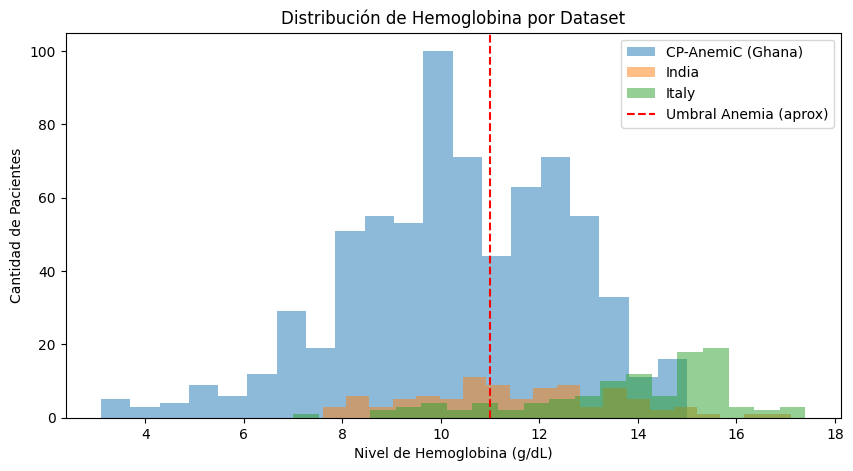

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 4. LIMPIEZA Y ESTANDARIZACIÓN DE DATOS
# ==========================================

# A) Estandarizar EDAD a AÑOS
# Si es de CP-AnemiC, dividimos por 12. Si es India/Italy, lo dejamos igual.
def normalizar_edad(row):
    if row['Dataset_Origen'] == 'CP-AnemiC (Ghana)':
        return row['Edad'] / 12.0  # Convertir meses a años
    else:
        return row['Edad']

df_final['Edad_Anios'] = df_final.apply(normalizar_edad, axis=1)

# B) Estandarizar GÉNERO
# Mapeamos todo a 0 (Mujer) y 1 (Hombre) o texto uniforme
mapa_genero = {
    'Female': 'F', 'Male': 'M',
    'F': 'F', 'M': 'M',
    'female': 'F', 'male': 'M'
}
df_final['Genero_Unif'] = df_final['Genero'].map(mapa_genero)

# C) Convertir Hemoglobina a numérico (por si acaso hay texto sucio)
df_final['Hemoglobina'] = pd.to_numeric(df_final['Hemoglobina'], errors='coerce')

# ==========================================
# 5. VERIFICACIÓN VISUAL (¡La prueba de fuego!)
# ==========================================

# Mostrar 10 filas ALEATORIAS (para ver mezcla de Ghana, India e Italia)
print("\n--- Muestra Aleatoria de Datos Procesados ---")
print(df_final[['Dataset_Origen', 'Hemoglobina', 'Edad_Anios', 'Genero_Unif']].sample(10))

# Estadísticas por Dataset
print("\n--- Promedios por Dataset ---")
print(df_final.groupby('Dataset_Origen')[['Hemoglobina', 'Edad_Anios']].mean())

# Gráfico de Distribución de Hemoglobina
plt.figure(figsize=(10, 5))
for dataset in df_final['Dataset_Origen'].unique():
    subset = df_final[df_final['Dataset_Origen'] == dataset]
    plt.hist(subset['Hemoglobina'], bins=20, alpha=0.5, label=dataset)

plt.axvline(x=11, color='r', linestyle='--', label='Umbral Anemia (aprox)')
plt.title('Distribución de Hemoglobina por Dataset')
plt.xlabel('Nivel de Hemoglobina (g/dL)')
plt.ylabel('Cantidad de Pacientes')
plt.legend()
plt.show()

In [7]:
from PIL import Image
import os

def limpiar_dataset(df, col_ruta):
    indices_a_eliminar = []
    print(f"🧐 Auditando {len(df)} imágenes. Esto puede tomar unos segundos...")

    for index, row in df.iterrows():
        img_path = row[col_ruta]

        try:
            # Intentamos abrir la imagen
            with Image.open(img_path) as img:
                img.verify() # Verifica la integridad del archivo sin cargarlo todo a RAM
        except (IOError, SyntaxError, Image.UnidentifiedImageError) as e:
            print(f"❌ Imagen corrupta detectada y eliminada: {img_path}")
            indices_a_eliminar.append(index)

    # Eliminamos las filas malas del DataFrame
    if len(indices_a_eliminar) > 0:
        df_limpio = df.drop(indices_a_eliminar)
        print(f"\n✅ Limpieza completada. Se eliminaron {len(indices_a_eliminar)} imágenes.")
        print(f"📉 Total inicial: {len(df)} -> Total final: {len(df_limpio)}")
        return df_limpio
    else:
        print("\n✅ Todas las imágenes están sanas. No se eliminó nada.")
        return df

# EJECUTAR LIMPIEZA
# Asegúrate de usar el nombre de tu dataframe principal (df_final)
df_final = limpiar_dataset(df_final, 'Ruta_Imagen')

🧐 Auditando 926 imágenes. Esto puede tomar unos segundos...
❌ Imagen corrupta detectada y eliminada: /content/MultiDiag-AI/India/1/20200118_164733_palpebral.png
❌ Imagen corrupta detectada y eliminada: /content/MultiDiag-AI/India/2/20200124_154320_palpebral.png
❌ Imagen corrupta detectada y eliminada: /content/MultiDiag-AI/India/10/20200203_091841_palpebral.png
❌ Imagen corrupta detectada y eliminada: /content/MultiDiag-AI/India/13/20200203_190841_palpebral.png
❌ Imagen corrupta detectada y eliminada: /content/MultiDiag-AI/India/16/20200204_155221_palpebral.png
❌ Imagen corrupta detectada y eliminada: /content/MultiDiag-AI/India/19/20200211_140525_palpebral.png
❌ Imagen corrupta detectada y eliminada: /content/MultiDiag-AI/India/22/20200211_150240_palpebral.png
❌ Imagen corrupta detectada y eliminada: /content/MultiDiag-AI/India/25/20200213_121216_palpebral.png
❌ Imagen corrupta detectada y eliminada: /content/MultiDiag-AI/India/28/20200213_150536_palpebral.png
❌ Imagen corrupta detect

# 2

Paso 1: Preparación de Etiquetas y Split de Datos
Primero definimos el umbral clínico. La OMS define anemia generalmente como Hb < 11.0 g/dL (varía según edad/embarazo, pero usaremos 11.0 como estándar general para este modelo).

--- Nueva Distribución de Clases (Criterio OMS) ---
Diagnostico
Anemia    493
Sano      372
Name: count, dtype: int64


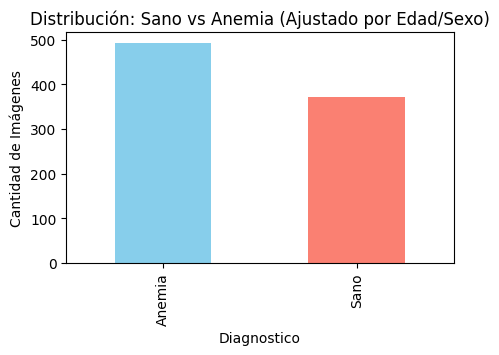


Resumen del Split:
Train Set: 605 imágenes
Valid Set: 130 imágenes
Test Set:  130 imágenes


In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# ==========================================
# 1. CLASIFICACIÓN CLÍNICA (Normas OMS)
# ==========================================

def clasificar_anemia_oms(row):
    hb = row['Hemoglobina']
    edad = row['Edad_Anios']
    genero = row['Genero_Unif'] # Esperamos 'M' o 'F'

    # Definimos el umbral límite (Cut-off) según la OMS
    umbral = 11.0 # Default para niños pequeños

    if edad < 5:
        umbral = 11.0
    elif 5 <= edad < 12:
        umbral = 11.5
    elif 12 <= edad < 15:
        umbral = 12.0
    else: # Adultos (>15 años)
        if genero == 'M':
            umbral = 13.0 # Hombres necesitan más Hb
        else:
            umbral = 12.0 # Mujeres no embarazadas

    # Retornamos la etiqueta y el umbral usado (para verificar si quieres)
    return 'Anemia' if hb < umbral else 'Sano'

# Aplicamos la función fila por fila (axis=1)
df_final['Diagnostico'] = df_final.apply(clasificar_anemia_oms, axis=1)

# ==========================================
# 2. VERIFICACIÓN DE CAMBIOS
# ==========================================
print("--- Nueva Distribución de Clases (Criterio OMS) ---")
conteo = df_final['Diagnostico'].value_counts()
print(conteo)

# Visualización rápida del balance
plt.figure(figsize=(5,3))
conteo.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribución: Sano vs Anemia (Ajustado por Edad/Sexo)')
plt.ylabel('Cantidad de Imágenes')
plt.show()

# ==========================================
# 3. SPLIT DE DATOS (Train/Val/Test)
# ==========================================
# Dividir en Train (70%), Val (15%), Test (15%)
# stratify=df_final['Diagnostico'] asegura que si hay 60% anemia,
# en train, val y test también haya 60% anemia.

train_df, temp_df = train_test_split(
    df_final,
    test_size=0.3,
    stratify=df_final['Diagnostico'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['Diagnostico'],
    random_state=42
)

print(f"\nResumen del Split:")
print(f"Train Set: {len(train_df)} imágenes")
print(f"Valid Set: {len(val_df)} imágenes")
print(f"Test Set:  {len(test_df)} imágenes")

Paso 2: Generadores de Imágenes (Data Augmentation)
Esto es vital. Como tenemos pocas fotos, "inventaremos" nuevas variaciones rotando y haciendo zoom para que el modelo aprenda a ignorar la posición del ojo.

In [40]:
BATCH_SIZE = 16 # Pequeño para que la red actualice pesos más frecuentemente
IMG_SIZE = (224, 224) # Tamaño nativo para EfficientNetB0

# Configuración de aumento de datos solo para TRAIN
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    #rescale=1./255,
    rotation_range=20,      # Rotar ojo
    width_shift_range=0.1,  # Mover horizontal
    height_shift_range=0.1, # Mover vertical
    shear_range=0.1,        # Inclinar
    zoom_range=0.2,         # Acercar/alejar
    horizontal_flip=True,   # Espejo (ojo izq/der)
    fill_mode='nearest'
)

# Para Val y Test SOLO reescalamos (no alteramos la realidad)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generadores
train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='Ruta_Imagen', y_col='Diagnostico',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)

val_gen = test_datagen.flow_from_dataframe(
    val_df, x_col='Ruta_Imagen', y_col='Diagnostico',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='Ruta_Imagen', y_col='Diagnostico',
    target_size=IMG_SIZE, batch_size=1, class_mode='binary', shuffle=False
)

Found 605 validated image filenames belonging to 2 classes.
Found 130 validated image filenames belonging to 2 classes.
Found 130 validated image filenames belonging to 2 classes.


In [41]:
import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras.applications.efficientnet import preprocess_input

# ==========================================
# 1. CORRECCIÓN DE GENERADORES (CRUCIAL)
# ==========================================
# EfficientNet quiere valores 0-255. NO usamos rescale=1./255 aquí.
# Usamos 'preprocessing_function' para que haga el ajuste exacto que pide el modelo.

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # <--- ESTO ES LA CLAVE
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input # Solo preprocesamiento, sin aumento
)

# Re-creamos los flujos de datos
train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='Ruta_Imagen', y_col='Diagnostico',
    target_size=(224, 224), batch_size=16, class_mode='binary'
)

val_gen = val_test_datagen.flow_from_dataframe(
    val_df, x_col='Ruta_Imagen', y_col='Diagnostico',
    target_size=(224, 224), batch_size=16, class_mode='binary'
)

test_gen = val_test_datagen.flow_from_dataframe(
    test_df, x_col='Ruta_Imagen', y_col='Diagnostico',
    target_size=(224, 224), batch_size=1, class_mode='binary', shuffle=False
)

# ==========================================
# 2. CALCULAR PESOS DE CLASE (Class Weights)
# ==========================================
# Esto castiga al modelo más fuerte si se equivoca en la clase minoritaria (Anemia)
classes = train_gen.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Pesos de clase calculados: {class_weights_dict}")
# Debería salir algo como {0: 0.8, 1: 1.3} (Anemia pesará más)

# ==========================================
# 3. MODELO CON FINE-TUNING (Descongelado)
# ==========================================
def build_unfrozen_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Descongelamos los últimos 20 bloques para que aprenda sobre TEJIDO HUMANO
    base_model.trainable = True

    # Congelamos las primeras capas (bordes y formas básicas) para no romper todo
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5), # Aumentamos dropout para evitar overfitting al descongelar
        layers.Dense(64, activation='relu'), # Reducimos densidad
        layers.Dense(1, activation='sigmoid')
    ])

    # Usamos un Learning Rate MUY BAJO porque descongelamos capas
    optimizer = optimizers.Adam(learning_rate=1e-5)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')])
    return model

model = build_unfrozen_model()

# ==========================================
# 4. ENTRENAMIENTO
# ==========================================
callbacks = [
    EarlyStopping(monitor='val_auc', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_auc', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
]

print("🚀 Iniciando entrenamiento corregido...")
history = model.fit(
    train_gen,
    epochs=40,
    validation_data=val_gen,
    class_weight=class_weights_dict, # <--- Aquí aplicamos el castigo
    callbacks=callbacks
)

Found 605 validated image filenames belonging to 2 classes.
Found 130 validated image filenames belonging to 2 classes.
Found 130 validated image filenames belonging to 2 classes.
Pesos de clase calculados: {0: np.float64(0.8768115942028986), 1: np.float64(1.1634615384615385)}
🚀 Iniciando entrenamiento corregido...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.4444 - auc: 0.4777 - loss: 1.1867 - recall: 0.6849 - val_accuracy: 0.6000 - val_auc: 0.6123 - val_loss: 0.6783 - val_recall: 0.5893 - learning_rate: 1.0000e-05
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.4722 - auc: 0.5281 - loss: 1.0624 - recall: 0.7541 - val_accuracy: 0.6000 - val_auc: 0.6091 - val_loss: 0.6819 - val_recall: 0.5357 - learning_rate: 1.0000e-05
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.4852 - auc: 0.5362 - loss: 1.0195 - recall: 0.6732 - val_accuracy: 0.6000 - val_auc: 0.6115 - val_loss: 0.6877 - val_recall: 0.5000 - learning_rate: 1.0000e-05
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5009 - auc: 0.5413 - loss: 1.0221 - recall: 0.7728 - val_accuracy: 0.6231 - val_auc: 0.6209 - val_loss: 0.6927 - val_recall: 0.5536 - learning_rate: 1.0000e-05
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5555 - auc: 0.5988 - loss: 0.9606 - recal

AQUIIIII

🧪 Evaluando en Test Set...
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step

--- Reporte de Métricas (Test Set) ---
              precision    recall  f1-score   support

        Sano       0.63      0.54      0.58        74
      Anemia       0.49      0.59      0.54        56

    accuracy                           0.56       130
   macro avg       0.56      0.56      0.56       130
weighted avg       0.57      0.56      0.56       130



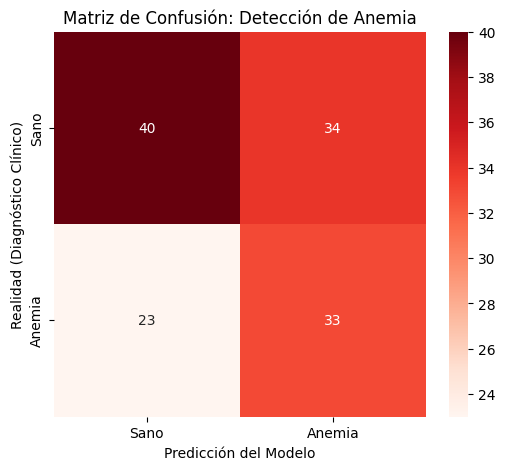

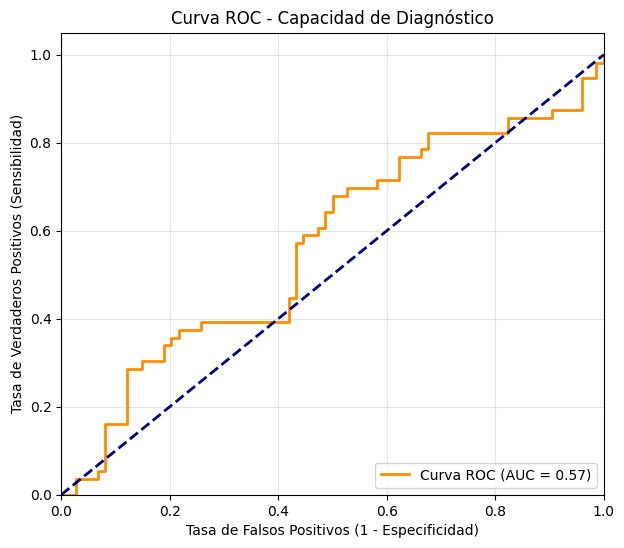

💾 Modelo guardado exitosamente en: /content/MultiDiag-AI/modelo_anemia_efficientnet.keras


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# 1. GENERAR PREDICCIONES FINALES
print("🧪 Evaluando en Test Set...")
test_gen.reset() # Reiniciar generador para asegurar orden
preds = model.predict(test_gen, verbose=1)
y_true = test_gen.classes

# 2. DEFINIR UMBRAL DE DECISIÓN
# En medicina, a veces bajamos el umbral para captar MÁS casos (ej: 0.4 en vez de 0.5)
# Aquí usaremos el estándar 0.5
y_pred_binary = (preds > 0.5).astype(int)

# 3. REPORTE DE CLASIFICACIÓN
print("\n--- Reporte de Métricas (Test Set) ---")
target_names = ['Sano', 'Anemia'] # 0: Sano, 1: Anemia
print(classification_report(y_true, y_pred_binary, target_names=target_names))

# 4. MATRIZ DE CONFUSIÓN VISUAL
cm = confusion_matrix(y_true, y_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusión: Detección de Anemia')
plt.ylabel('Realidad (Diagnóstico Clínico)')
plt.xlabel('Predicción del Modelo')
plt.show()

# 5. CURVA ROC Y AUC
fpr, tpr, thresholds = roc_curve(y_true, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curva ROC - Capacidad de Diagnóstico')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# 6. GUARDADO FINAL DEL MODELO
model_save_path = '/content/MultiDiag-AI/modelo_anemia_efficientnet.keras'
model.save(model_save_path)
print(f"💾 Modelo guardado exitosamente en: {model_save_path}")

  Paso 3: Construcción del Modelo (Transfer Learning)

In [21]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers

def build_efficientnet_model():
    # 1. Cargar base pre-entrenada (sin la "cabeza" clasificadora)
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Congelar capas base (para no destruir lo aprendido en ImageNet)
    base_model.trainable = False

    # 2. Crear nueva cabeza personalizada
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(), # Convierte mapas de características en vector
        layers.BatchNormalization(),      # Estabiliza el aprendizaje
        layers.Dropout(0.4),              # Apaga 40% de neuronas al azar (Evita Overfitting)
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid') # Salida binaria: 0 a 1
    ])

    # 3. Compilar
    # Usamos learning rate bajo para ajuste fino
    optimizer = optimizers.Adam(learning_rate=1e-4)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')])

    return model

model = build_efficientnet_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,218,788 (16.09 MB)

 Trainable params: 166,657 (651.00 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

Paso 4: Entrenamiento con Callbacks
Usaremos EarlyStopping para que el entrenamiento se detenga si el modelo deja de mejorar, ahorrando tiempo y evitando sobreajuste.

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_anemia_model.keras', monitor='val_auc', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

history = model.fit(
    train_gen,
    epochs=30, # Ponemos bastantes, el EarlyStopping lo cortará antes si es necesario
    validation_data=val_gen,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5061 - auc: 0.4722 - loss: 0.7654 - recall: 0.3334
Epoch 1: val_auc improved from -inf to 0.50000, saving model to best_anemia_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.5066 - auc: 0.4723 - loss: 0.7655 - recall: 0.3334 - val_accuracy: 0.5692 - val_auc: 0.5000 - val_loss: 0.6873 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5511 - auc: 0.5313 - loss: 0.7268 - recall: 0.4026
Epoch 2: val_auc did not improve from 0.50000
38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5516 - auc: 0.5320 - loss: 0.7265 - recall: 0.4036 - val_accuracy: 0.5692 - val_auc: 0.5000 - val_loss: 0.6854 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5139 - auc: 0.4824 - loss: 0.7840 - recall: 0.3799
Epoch 3: val_auc did not improve from 0.50000
38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - acc

Paso 5: Evaluación y Métricas Médicas
En medicina, el Accuracy es engañoso. Nos importa el Recall (Sensibilidad): De todos los que tienen anemia, ¿a cuántos detecté? (No queremos mandar a casa a alguien enfermo).

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step


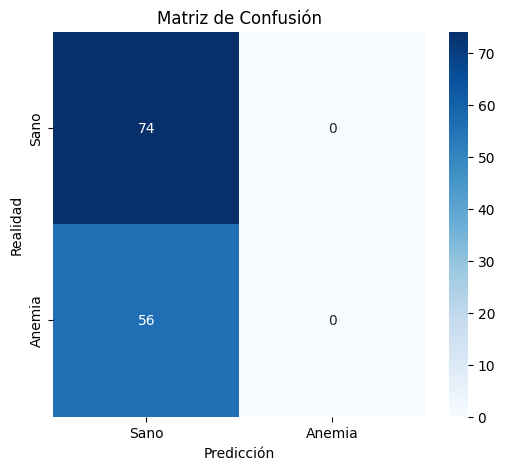

              precision    recall  f1-score   support

        Sano       0.57      1.00      0.73        74
      Anemia       0.00      0.00      0.00        56

    accuracy                           0.57       130
   macro avg       0.28      0.50      0.36       130
weighted avg       0.32      0.57      0.41       130



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


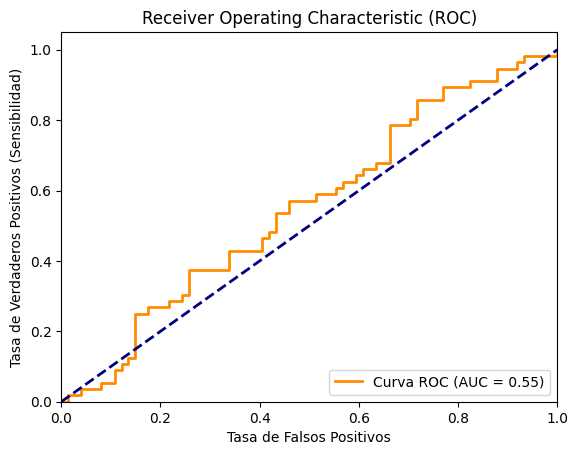

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# 1. Predicciones
# Aseguramos resetear el generador para que coincida el orden
test_gen.reset()
preds = model.predict(test_gen, verbose=1)
y_pred_binary = (preds > 0.5).astype(int) # Umbral de decisión 0.5
y_true = test_gen.classes

# 2. Matriz de Confusión Visual
cm = confusion_matrix(y_true, y_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sano', 'Anemia'], yticklabels=['Sano', 'Anemia'])
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión')
plt.show()

# 3. Reporte Completo
print(classification_report(y_true, y_pred_binary, target_names=['Sano', 'Anemia']))

# 4. Curva ROC (Para papers y tesis)
fpr, tpr, thresholds = roc_curve(y_true, preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


# DENSENET

In [9]:
!pip install -q -U keras-tuner

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
import keras_tuner as kt
import numpy as np
from sklearn.utils import class_weight

# ==========================================
# 1. GENERADORES CON ENFOQUE EN COLOR
# ==========================================
# Agregamos channel_shift_range: esto cambia aleatoriamente los valores RGB
# para simular diferentes sensores de cámara y condiciones de luz.

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # DenseNet usa su propio pre-proceso
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    channel_shift_range=20.0, # <--- CLAVE: Variación de color simulada
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Re-generamos los flujos (Asegúrate de que train_df, val_df, test_df existan del paso anterior)
train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='Ruta_Imagen', y_col='Diagnostico',
    target_size=(224, 224), batch_size=16, class_mode='binary'
)

val_gen = val_test_datagen.flow_from_dataframe(
    val_df, x_col='Ruta_Imagen', y_col='Diagnostico',
    target_size=(224, 224), batch_size=16, class_mode='binary'
)

test_gen = val_test_datagen.flow_from_dataframe(
    test_df, x_col='Ruta_Imagen', y_col='Diagnostico',
    target_size=(224, 224), batch_size=1, class_mode='binary', shuffle=False
)

# Calcular pesos de clase (Vital para datasets desbalanceados)
classes = train_gen.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Pesos de clase: {class_weights_dict}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.7 MB/s eta 0:00:00
Found 605 validated image filenames belonging to 2 classes.
Found 130 validated image filenames belonging to 2 classes.
Found 130 validated image filenames belonging to 2 classes.
Pesos de clase: {0: np.float64(0.8768115942028986), 1: np.float64(1.1634615384615385)}


Paso 2: Definición del Hipermodelo (Grid Search)
Aquí definimos qué cosas va a probar la IA automáticamente. Probará:

Descongelar diferentes cantidades de capas.

Diferentes tasas de aprendizaje (Learning Rates).

Diferentes niveles de Dropout.

In [10]:
def build_model(hp):
    # 1. Base Médica: DenseNet121
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # 2. Hyperparámetro: ¿Cuántas capas descongelar?
    # DenseNet es profunda. Probaremos descongelar las ultimas 10, 30 o 50 capas.
    base_model.trainable = True
    fine_tune_at = hp.Int('fine_tune_layers', min_value=10, max_value=50, step=20)

    # Congelar todo EXCEPTO las ultimas 'fine_tune_at' capas
    for layer in base_model.layers[:-fine_tune_at]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),

        # 3. Hyperparámetro: Dropout (0.3 a 0.6)
        layers.Dropout(hp.Float('dropout', 0.3, 0.6, step=0.1)),

        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    # 4. Hyperparámetro: Learning Rate
    # Probamos tasas muy pequeñas para no romper los pesos pre-entrenados
    lr = hp.Choice('learning_rate', values=[1e-4, 1e-5, 5e-6])

    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

# Configurar el Tuner (Buscador)
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("val_auc", direction="max"), # ¡Queremos maximizar AUC!
    max_epochs=15,
    factor=3,
    directory='anemia_tuner_dir',
    project_name='densenet_optimization'
)

# Ejecutar la búsqueda (Esto tomará unos 10-15 minutos)
print("🕵️ Iniciando Grid Search (Hyperband)...")
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(train_gen, epochs=15, validation_data=val_gen, class_weight=class_weights_dict, callbacks=[stop_early])

# Obtener los mejores hiperparámetros encontrados
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
✅ Búsqueda completada.
Mejor Learning Rate: {best_hps.get('learning_rate')}
Mejor Dropout: {best_hps.get('dropout')}
Capas descongeladas: {best_hps.get('fine_tune_layers')}
""")

Trial 30 Complete [00h 08m 53s]
val_auc: 0.6348937749862671

Best val_auc So Far: 0.815395712852478
Total elapsed time: 03h 44m 31s

✅ Búsqueda completada.
Mejor Learning Rate: 0.0001
Mejor Dropout: 0.5
Capas descongeladas: 30



Paso 3: Entrenar el Mejor Modelo Encontrado
Ahora tomamos la "mejor receta" que encontró el Grid Search y la entrenamos hasta el final.

In [11]:
# Construir modelo con los mejores hiperparámetros
model = tuner.hypermodel.build(best_hps)

# Callbacks para el entrenamiento final
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=8, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, verbose=1)
]

print("🚀 Entrenando el modelo optimizado FINAL...")
history = model.fit(
    train_gen,
    epochs=40, # Le damos tiempo, el EarlyStopping cortará si es necesario
    validation_data=val_gen,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

🚀 Entrenando el modelo optimizado FINAL...
Epoch 1/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.5035 - auc: 0.5389 - loss: 0.8042 - val_accuracy: 0.4538 - val_auc: 0.5056 - val_loss: 0.7465 - learning_rate: 1.0000e-04
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5213 - auc: 0.5574 - loss: 0.7411 - val_accuracy: 0.5077 - val_auc: 0.5510 - val_loss: 0.6993 - learning_rate: 1.0000e-04
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.5921 - auc: 0.6587 - loss: 0.6854 - val_accuracy: 0.5308 - val_auc: 0.5763 - val_loss: 0.6797 - learning_rate: 1.0000e-04
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5681 - auc: 0.5976 - loss: 0.7231
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
38/38 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.5688 - auc: 0.5985 - loss: 0.7226 - val_accuracy: 0.5692 - val_auc: 0.6231 - val_loss: 0.6581 - learning_rate: 1.0000e-04
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step 

Paso 4: Evaluación y Métricas Finales

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step

--- REPORTE FINAL DENSENET OPTIMIZADO ---
              precision    recall  f1-score   support

        Sano       0.78      0.78      0.78        74
      Anemia       0.71      0.71      0.71        56

    accuracy                           0.75       130
   macro avg       0.75      0.75      0.75       130
weighted avg       0.75      0.75      0.75       130



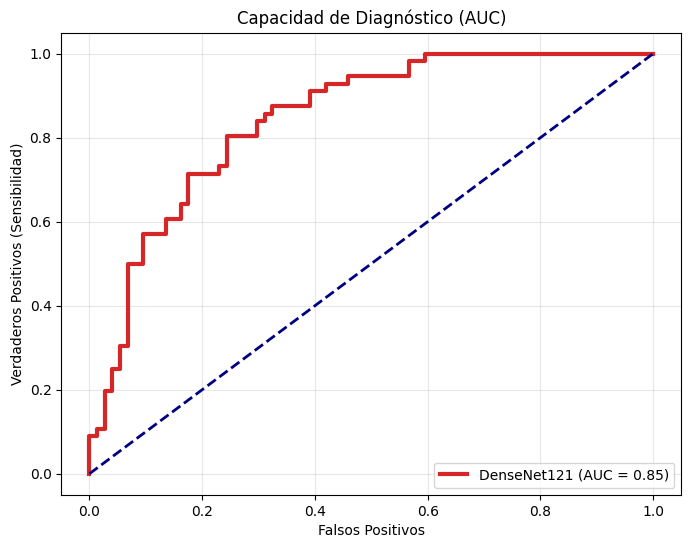

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Predecir en Test
test_gen.reset()
preds = model.predict(test_gen, verbose=1)
y_true = test_gen.classes
y_pred_binary = (preds > 0.5).astype(int)

# Reporte
print("\n--- REPORTE FINAL DENSENET OPTIMIZADO ---")
print(classification_report(y_true, y_pred_binary, target_names=['Sano', 'Anemia']))

# Curva ROC (La métrica reina)
fpr, tpr, thresholds = roc_curve(y_true, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#d62728', lw=3, label=f'DenseNet121 (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos (Sensibilidad)')
plt.title('Capacidad de Diagnóstico (AUC)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Guardar
model.save('/content/MultiDiag-AI/best_medical_anemia_model.keras')

🎯 Umbral Óptimo para Recall > 85.0%: 0.4404

--- REPORTE CON UMBRAL AJUSTADO (Prioridad Sensibilidad) ---
              precision    recall  f1-score   support

        Sano       0.86      0.69      0.77        74
      Anemia       0.68      0.86      0.76        56

    accuracy                           0.76       130
   macro avg       0.77      0.77      0.76       130
weighted avg       0.78      0.76      0.76       130



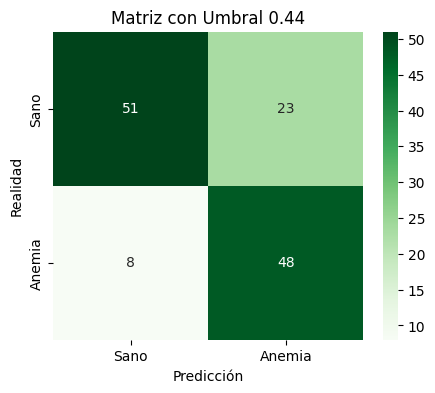

In [14]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 1. Obtener datos de la curva ROC calculada anteriormente
# fpr, tpr, thresholds ya los tienes del bloque anterior

# 2. Estrategia: "Quiero al menos 90% de Sensibilidad (Recall)"
target_recall = 0.85

# Buscamos el primer índice donde el TPR (Recall) sea mayor o igual al target
# np.argmax devuelve el primer indice que cumple la condición
idx = np.argmax(tpr >= target_recall)
optimal_threshold = thresholds[idx]

print(f"🎯 Umbral Óptimo para Recall > {target_recall*100}%: {optimal_threshold:.4f}")

# 3. Aplicar nuevo umbral a las predicciones
# Si la probabilidad es mayor que el nuevo umbral, es Anemia (1)
y_pred_optimizado = (preds >= optimal_threshold).astype(int)

# 4. Nuevo Reporte
print("\n--- REPORTE CON UMBRAL AJUSTADO (Prioridad Sensibilidad) ---")
print(classification_report(y_true, y_pred_optimizado, target_names=['Sano', 'Anemia']))

# 5. Nueva Matriz de Confusión
cm = confusion_matrix(y_true, y_pred_optimizado)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Sano', 'Anemia'], yticklabels=['Sano', 'Anemia'])
plt.title(f'Matriz con Umbral {optimal_threshold:.2f}')
plt.ylabel('Realidad')
plt.xlabel('Predicción')
plt.show()

🎯 Umbral Óptimo para Recall > 90.0%: 0.3863

--- REPORTE CON UMBRAL AJUSTADO (Prioridad Sensibilidad) ---
              precision    recall  f1-score   support

        Sano       0.90      0.61      0.73        74
      Anemia       0.64      0.91      0.75        56

    accuracy                           0.74       130
   macro avg       0.77      0.76      0.74       130
weighted avg       0.79      0.74      0.74       130



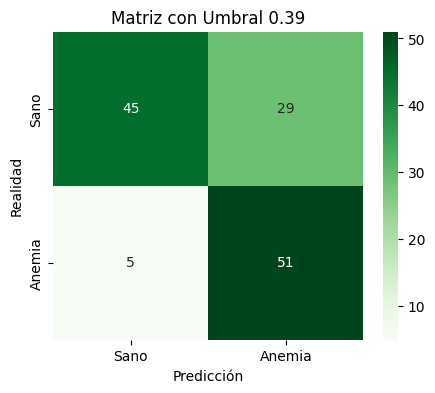

In [15]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 1. Obtener datos de la curva ROC calculada anteriormente
# fpr, tpr, thresholds ya los tienes del bloque anterior

# 2. Estrategia: "Quiero al menos 90% de Sensibilidad (Recall)"
target_recall = 0.90

# Buscamos el primer índice donde el TPR (Recall) sea mayor o igual al target
# np.argmax devuelve el primer indice que cumple la condición
idx = np.argmax(tpr >= target_recall)
optimal_threshold = thresholds[idx]

print(f"🎯 Umbral Óptimo para Recall > {target_recall*100}%: {optimal_threshold:.4f}")

# 3. Aplicar nuevo umbral a las predicciones
# Si la probabilidad es mayor que el nuevo umbral, es Anemia (1)
y_pred_optimizado = (preds >= optimal_threshold).astype(int)

# 4. Nuevo Reporte
print("\n--- REPORTE CON UMBRAL AJUSTADO (Prioridad Sensibilidad) ---")
print(classification_report(y_true, y_pred_optimizado, target_names=['Sano', 'Anemia']))

# 5. Nueva Matriz de Confusión
cm = confusion_matrix(y_true, y_pred_optimizado)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Sano', 'Anemia'], yticklabels=['Sano', 'Anemia'])
plt.title(f'Matriz con Umbral {optimal_threshold:.2f}')
plt.ylabel('Realidad')
plt.xlabel('Predicción')
plt.show()

In [16]:
# ==========================================
# GUARDADO PROFESIONAL
# ==========================================

# 1. Guardar el modelo (Formato nativo Keras 3.0+)
model_path = '/content/MultiDiag-AI/modelo_anemia_densenet_opt.keras'
model.save(model_path)
print(f"✅ Modelo guardado en: {model_path}")

# ==========================================
# DOCUMENTACIÓN TÉCNICA (Para poner en tu API/App)
# ==========================================
print("\n" + "="*30)
print("📘 ESPECIFICACIONES DEL MODELO")
print("="*30)
print("1. ARQUITECTURA: DenseNet121 (Transfer Learning + Fine Tuning)")
print("2. INPUT (Entrada):")
print("   - Tensor de forma: (1, 224, 224, 3)")
print("   - Color: RGB")
print("   - Preprocesamiento OBLIGATORIO: tensorflow.keras.applications.densenet.preprocess_input")
print("     (No usar simple rescale 1/255, DenseNet usa su propia normalización).")
print("\n3. OUTPUT (Salida):")
print("   - Tipo: Float (Probabilidad de Anemia)")
print("   - Rango: [0.0, 1.0]")
print(f"   - Umbral de Decisión Sugerido: {optimal_threshold:.4f} (Para alta sensibilidad)")
print("\n4. INTERPRETACIÓN:")
print(f"   - Si valor < {optimal_threshold:.4f} --> SANO")
print(f"   - Si valor >= {optimal_threshold:.4f} --> ANEMIA (Derivar a test de sangre)")

✅ Modelo guardado en: /content/MultiDiag-AI/modelo_anemia_densenet_opt.keras

📘 ESPECIFICACIONES DEL MODELO
1. ARQUITECTURA: DenseNet121 (Transfer Learning + Fine Tuning)
2. INPUT (Entrada):
   - Tensor de forma: (1, 224, 224, 3)
   - Color: RGB
   - Preprocesamiento OBLIGATORIO: tensorflow.keras.applications.densenet.preprocess_input
     (No usar simple rescale 1/255, DenseNet usa su propia normalización).

3. OUTPUT (Salida):
   - Tipo: Float (Probabilidad de Anemia)
   - Rango: [0.0, 1.0]
   - Umbral de Decisión Sugerido: 0.3863 (Para alta sensibilidad)

4. INTERPRETACIÓN:
   - Si valor < 0.3863 --> SANO
   - Si valor >= 0.3863 --> ANEMIA (Derivar a test de sangre)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')